#### About Baseline Model

- Baseline is essentially required to set the benchmark for model performance. Based on which other models can be considered as better or not.
- Persistance baseline considers timeseries time sequence factor and gives baseline performance without any training needed

#### About `Persistance Baseline Algorithm`

- The most common baseline method for supervised machine learning is the `Zero Rule algorithm`.
- This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets.
- The equivalent technique for use with time series dataset is the `persistence algorithm`.

Reference and credits to author : https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [2]:
np.random.seed(10) #Reproducible results

time = pd.date_range(start="2021-03-01", end="2021-04-08").to_pydatetime().tolist()
print("Time:")
print(type(time))
print(time,"\n")

value = np.random.uniform(low=0, high=10, size=(len(time),)).astype(int)
print("Money Demand:")
print(type(value))
print(value)

df = pd.DataFrame({"Time":time,"MoneyDemand":value})
df.index = df.Time.tolist()
df.head(5)

Time:
<class 'list'>
[datetime.datetime(2021, 3, 1, 0, 0), datetime.datetime(2021, 3, 2, 0, 0), datetime.datetime(2021, 3, 3, 0, 0), datetime.datetime(2021, 3, 4, 0, 0), datetime.datetime(2021, 3, 5, 0, 0), datetime.datetime(2021, 3, 6, 0, 0), datetime.datetime(2021, 3, 7, 0, 0), datetime.datetime(2021, 3, 8, 0, 0), datetime.datetime(2021, 3, 9, 0, 0), datetime.datetime(2021, 3, 10, 0, 0), datetime.datetime(2021, 3, 11, 0, 0), datetime.datetime(2021, 3, 12, 0, 0), datetime.datetime(2021, 3, 13, 0, 0), datetime.datetime(2021, 3, 14, 0, 0), datetime.datetime(2021, 3, 15, 0, 0), datetime.datetime(2021, 3, 16, 0, 0), datetime.datetime(2021, 3, 17, 0, 0), datetime.datetime(2021, 3, 18, 0, 0), datetime.datetime(2021, 3, 19, 0, 0), datetime.datetime(2021, 3, 20, 0, 0), datetime.datetime(2021, 3, 21, 0, 0), datetime.datetime(2021, 3, 22, 0, 0), datetime.datetime(2021, 3, 23, 0, 0), datetime.datetime(2021, 3, 24, 0, 0), datetime.datetime(2021, 3, 25, 0, 0), datetime.datetime(2021, 3, 26, 0, 0),

,Time,MoneyDemand
2021-03-01,2021-03-01,7
2021-03-02,2021-03-02,0
2021-03-03,2021-03-03,6
2021-03-04,2021-03-04,7
2021-03-05,2021-03-05,4


In [3]:
df_train = df[df["Time"]<="2021-03-31"]
df_test = df[df["Time"]>"2021-03-31"]

print("Train:")
print(df_train.tail(5), "\n")
print("Test:")
print(df_test,"\n")

Train:
                 Time  MoneyDemand
2021-03-27 2021-03-27            6
2021-03-28 2021-03-28            5
2021-03-29 2021-03-29            6
2021-03-30 2021-03-30            6
2021-03-31 2021-03-31            8 

Test:
                 Time  MoneyDemand
2021-04-01 2021-04-01            5
2021-04-02 2021-04-02            9
2021-04-03 2021-04-03            3
2021-04-04 2021-04-04            0
2021-04-05 2021-04-05            3
2021-04-06 2021-04-06            1
2021-04-07 2021-04-07            8
2021-04-08 2021-04-08            0 



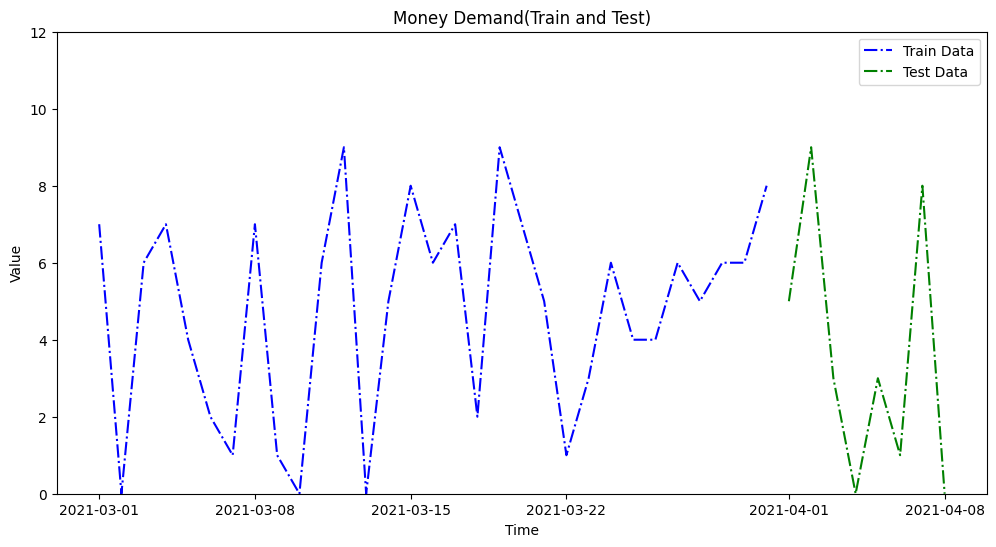

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

axes.plot(df_train.index, df_train.MoneyDemand, "b-.", label="Train Data")
axes.plot(df_test.index, df_test.MoneyDemand, "g-.", label="Test Data")

axes.set_title("Money Demand(Train and Test)")
axes.set_ylabel("Value")
axes.set_xlabel("Time")

axes.set_ylim([0,12])

plt.legend(loc="upper right")
plt.show()

In [5]:
df_temp = df["MoneyDemand"].copy(deep=True)#.reset_index(drop=True)
print(df_temp.head(5))

df_shift = pd.concat([df_temp.shift(1), df_temp], axis=1)
df_shift.columns = ['t-1', 't+1']
# df_shift.reset_index(drop=True, inplace=True)
print(df_shift.head(5))

2021-03-01    7
2021-03-02    0
2021-03-03    6
2021-03-04    7
2021-03-05    4
Name: MoneyDemand, dtype: int64
            t-1  t+1
2021-03-01  NaN    7
2021-03-02  7.0    0
2021-03-03  0.0    6
2021-03-04  6.0    7
2021-03-05  7.0    4


In [6]:
train_X, train_y = df_shift.iloc[df_shift.index<="2021-03-31",0], df_shift.iloc[df_shift.index<="2021-03-31",1]
test_X, test_y = df_shift.iloc[df_shift.index>"2021-03-31",0], df_shift.iloc[df_shift.index>"2021-03-31",1]

In [7]:
print(train_X.tail(5))
print(train_y.tail(5))

2021-03-27    4.0
2021-03-28    6.0
2021-03-29    5.0
2021-03-30    6.0
2021-03-31    6.0
Name: t-1, dtype: float64
2021-03-27    6
2021-03-28    5
2021-03-29    6
2021-03-30    6
2021-03-31    8
Name: t+1, dtype: int64


In [8]:
print(test_X.tail(5))
print(test_y.tail(5))

2021-04-04    3.0
2021-04-05    0.0
2021-04-06    3.0
2021-04-07    1.0
2021-04-08    8.0
Name: t-1, dtype: float64
2021-04-04    0
2021-04-05    3
2021-04-06    1
2021-04-07    8
2021-04-08    0
Name: t+1, dtype: int64


In [9]:
# persistence model
def model_persistence(x):
    return x

In [10]:
# Walk-foward validation
pred_list = []
for x in test_X:
    yhat = model_persistence(x)
    pred_list.append(yhat)
test_performance = mean_squared_error(test_y, pred_list)
print('Test Data MSE: %.3f' % test_performance)

Test Data MSE: 24.500


In [11]:
df_test

,Time,MoneyDemand
2021-04-01,2021-04-01,5
2021-04-02,2021-04-02,9
2021-04-03,2021-04-03,3
2021-04-04,2021-04-04,0
2021-04-05,2021-04-05,3
2021-04-06,2021-04-06,1
2021-04-07,2021-04-07,8
2021-04-08,2021-04-08,0


In [12]:
df_shift.iloc[df_shift.index>"2021-03-31"]

,t-1,t+1
2021-04-01,8.0,5
2021-04-02,5.0,9
2021-04-03,9.0,3
2021-04-04,3.0,0
2021-04-05,0.0,3
2021-04-06,3.0,1
2021-04-07,1.0,8
2021-04-08,8.0,0


In [13]:
test_y

2021-04-01    5
2021-04-02    9
2021-04-03    3
2021-04-04    0
2021-04-05    3
2021-04-06    1
2021-04-07    8
2021-04-08    0
Name: t+1, dtype: int64

In [14]:
pred_list

[8.0, 5.0, 9.0, 3.0, 0.0, 3.0, 1.0, 8.0]

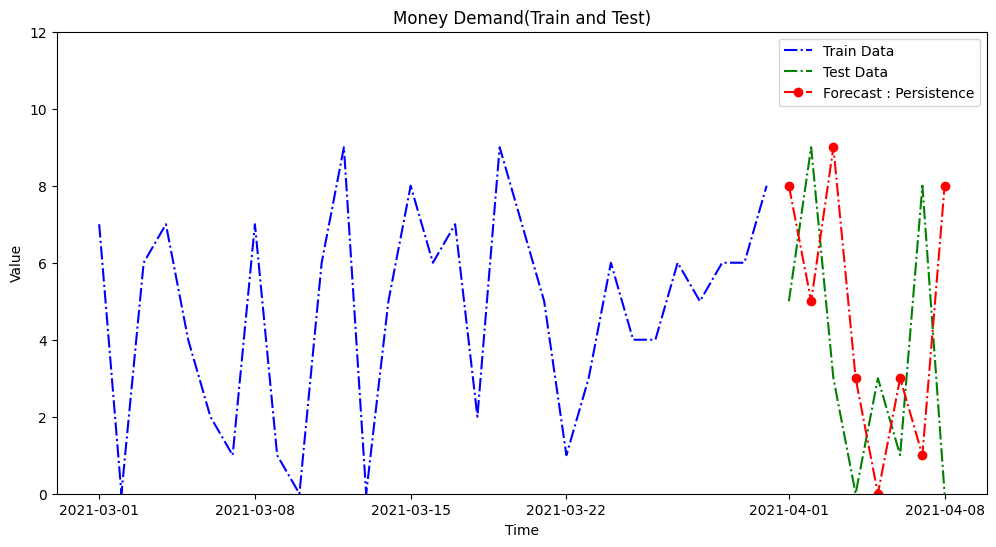

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

axes.plot(train_y.index, train_y, "b-.", label="Train Data")
axes.plot(test_y.index, test_y, "g-.", label="Test Data")
axes.plot(test_y.index, pred_list, "or-.", label="Forecast : Persistence")

axes.set_title("Money Demand(Train and Test)")
axes.set_ylabel("Value")
axes.set_xlabel("Time")

axes.set_ylim([0,12])

plt.legend(loc="upper right")
plt.show()

#### `Final Take Aways`

- Convert your univariate timeseries data into dataframe and supervised data format
- Input variable/variables are lagged values ex:- t-1
- Output variable is ex:- t+1
- Now split data into train and test for :- Move forward evaluation
- Consider test[t-1] as yhat of persistance algorithm predictions
- test[t+1] as actual predictions
- Calculate performance based of yhat and actual predictions. Now this becomes your baseline[persistence algorithm] performance.
- The model which gives more performance this can be considered as skillfull
- In short, the persistence baseline (or zero-rule algorithm) uses the last observed value (lagged value) as the prediction for the next time step, serving as a simple benchmark for time series forecasting.